<a href="https://colab.research.google.com/github/yanglinjing/dsnd_p2_img_classifier/blob/master/image_classifier_project_googlecolab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, I trained an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. 
[The dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) includes ***102 ***flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
!pwd

/content


In [3]:
#google colab - change path to google drive

import os 
os.chdir('drive/My Drive/Colab Notebooks/dsnd_p2_img_classification')
!pwd

/content/drive/My Drive/Colab Notebooks/dsnd_p2_img_classification


In [4]:
!ls


 assets		   'Image Classifier Project.ipynb'	     py
 cat_to_name.json   Image_Classifier_Project_jupyter.ipynb   __pycache__
 checkpoint.pth     LICENSE				     README.md
 flowers	    materials


In [5]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import time
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn, optim
import torch.nn.functional as F

from torchvision import datasets, transforms, models

import json


## Load the data

Here you'll use `torchvision` to load the data ([torchvision](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data can be [downloaded here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, **training**, **validation**, and **testing**. 

- For the **training**, you'll want to apply transformations such as ***random scaling, cropping, and flipping***. This will help the network generalize leading to better performance. You'll also need to make sure the input data is ***resized*** to** 224x224 **pixels as required by the pre-trained networks.

- The **validation** and **testing** sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to ***resize*** then ***crop*** the images to the appropriate size.

The **pre-trained **networks were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets, the means and standard deviations of the images are normalized to what the network expects. Calculated from the ImageNet images,
- the **means** are `[0.485, 0.456, 0.406]` and 
- the** standard deviations** are `[0.229, 0.224, 0.225]`.  

These values will shift each ***color*** channel to be centered at 0 and range ***from -1 to 1***.
 

In [0]:
# all parameters

batch_size = 32
learning_rate = 0.001
drop_out = 0.5
epochs = 3

arch = 'vgg16'
input_size = 25088
output_size = 102
hidden_layers = 4096

pretrained_mean = [0.485, 0.456, 0.406]
pretrained_std = [0.229, 0.224, 0.225]


In [0]:
# to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# to CPU
cpu = torch.device("cpu" if device.type == 'cuda' else 'cpu')

In [0]:
# Define your transforms for the training, validation, and testing sets

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),# Randomly Rotate 30 degrees
        transforms.RandomResizedCrop(224),#Randomly Resize Img, then Crop to 224 * 224 px
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=pretrained_mean, std=pretrained_std)
     ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=pretrained_mean, std=pretrained_std)
     ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=pretrained_mean, std=pretrained_std)
     ])
}


In [0]:
# Load the datasets with ImageFolder
data_dir = 'flowers'

image_datasets = {
    x: datasets.ImageFolder(root = data_dir + '/' + x, 
                            transform = data_transforms[x])
    for x in list(data_transforms.keys())
}

# This code cell is retrived from 
# https://github.com/miguelangel/ai--transfer-learning-for-image-classification

#image_datasets

In [0]:
# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {
    x : torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size = batch_size, 
                                              shuffle = True)
    for x in list(data_transforms.keys())
}

#dataloaders

In [12]:
#TODO: Know your data
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes

print ("Dasaset Size: "+ str(dataset_sizes) + "\n")
n_class = len(class_names)
print ("Number of classes: "+ str(n_class) + "\n")
print ("Classes: "+ str(class_names) + "\n")

print (f'Number of dataloaders: {len(dataloaders)}')

# This code cell is copied from 
# https://github.com/rajesh-iiith/AIPND-ImageClassifier/blob/master/Image%20Classifier%20Project.ipynb

Dasaset Size: {'train': 6552, 'valid': 818, 'test': 819}

Number of classes: 102

Classes: ['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']

Number of dataloaders: 3


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [0]:
# import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)    

# cat_to_name

The size of image: 224


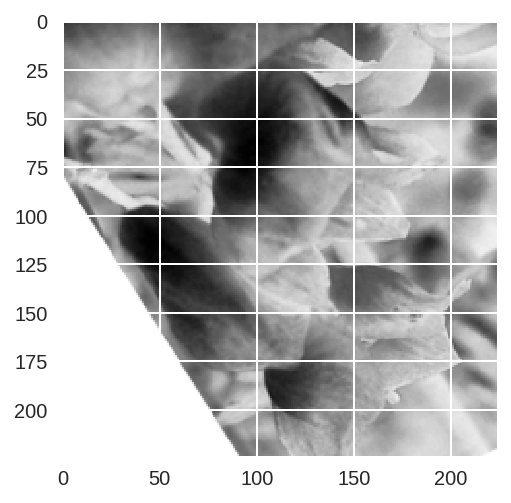

In [14]:
### View an image
images, labels = next(iter(dataloaders["train"]))
print(f'The size of image: {len(images[0,2])}')
plt.imshow(images[0,0])

# Building & Training the Classifier

Now that the data is ready, it's time to build and train the classifier. I used one of the pretrained models from `torchvision.models` to get the image ***features***, then built and trained a new feed-forward classifier using those features.

The steps are as follows:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

When training make sure you're updating only the ***weights*** of the feed-forward network. 

You should be able to get the validation ***accuracy*** above 70% if you build everything right. 

Make sure to try different ***hyperparameters*** (learning rate, units in the classifier, epochs, etc) to find the best model. 

Save those hyperparameters to use as ***default values ***in the next part of the project.

### Load a pre-trained network - VGG

In [0]:
def load_model(arch='vgg16'):
    # load the model trained on ImageNet: VGG or alexnet
    if arch=='vgg16':
        model = models.vgg16(pretrained=True)
    elif arch=='alexnet':
        model = models.alexnet(pretrained=True)
    else:
        raise ValueError('{} is not available. Please choose "vgg19" or "alexnet"'.format(arch))
    
    return model
  
# The structure of models might be different
# e.g. vgg16 & alexnet uses 'clasiffier', whereas resnet50 uses 'fc' for classifier
# in our 'build_model()', we uses 'classifier'

In [16]:
# check its original classifiers
load_model().classifier

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
553433881it [00:32, 17272472.97it/s]


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

### Define a New Model
Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout

In [0]:
# use a pre-traind model to define my model

def build_model(arch,
                input_size, 
                output_size, 
                hidden_layers,
                learning_rate,
                drop_out):
  
  # load the model trained on ImageNet
  model = load_model(arch)
  
  # Freezing Parameters
  for param in model.parameters(): # instead of using for param in model.features
    param.require_grad = False # Turn off gradients for the model
  
  # Define new classifier
  classifier = nn.Sequential(nn.Linear(input_size, hidden_layers),
                             nn.ReLU(),
                             nn.Dropout(p = drop_out),
                             nn.Linear(hidden_layers, output_size),
                             nn.LogSoftmax(dim = 1))
    
  
  # update model
  model.classifier = classifier
  
  # put model into GPU
  model.to(device)
  
  # Define Loss
  criterion = nn.NLLLoss()
  
  # Define Optimiser
  optimizer = optim.Adam(model.classifier.parameters(), # use parameters in model
                         lr = learning_rate) # learning rate
  
  return model, optimizer, criterion 

In [0]:
model, optimizer, criterion = build_model(arch,
                                          input_size, 
                                          output_size, 
                                          hidden_layers,
                                          learning_rate,
                                          drop_out)

In [19]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=102, bias=True)
  (4): LogSoftmax()
)

In [20]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [21]:
criterion

NLLLoss()

### Train &  Validation
- **Train** the classifier layers using backpropagation using the pre-trained network to get the features

- Track the loss and accuracy on the **validation** set to determine the best hyperparameters

In [0]:
# used for validation and testing

def validation(phase,
               dataloaders,
               device,
               model,
               criterion):

  test_loss = 0
  accuracy = 0
  
  # turn off dropout
  model.eval()

  with torch.no_grad():
  
    # use valid data
    for images, labels in dataloaders[phase]:

      # transfer tensors to GPU
      images, labels = images.to(device), labels.to(device) 

      #1 Calculate Loss
      logps = model(images)
      test_loss += criterion(logps, labels).item()

      #2 Calculate Accuracy
      ps = torch.exp(logps) 
      # Our model returns logSoftmax, which is Log probability of the classes, so we need exp of it

      ## get 1st largest value & probability  
      ## check equality with labels: whether predicted classes match actual ones
      equality = (labels.data == ps.max(1)[1]) # dim=1 column

      ## calculate accuracy by equality
      accuracy += equality.type_as(torch.FloatTensor()).mean()
    
  return test_loss,  accuracy

In [0]:
def train(dataloaders,
         device,
         model,
         criterion,
         optimizer,
         epochs, 
         print_every = 40): # print records after every 40 images 
  
  start = time.time()
  
  # Define variables to be used in training
  steps = 0
  running_loss = 0

  for epoch in range(epochs):

    # use training data
    for images, labels in dataloaders['train']:
      
      # transfer tensors to GPU
      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad() # gradient = 0
      
      steps += 1

      #1 forward
      logps = model(images) # log probabilities

      #2 calculate loss
      loss = criterion(logps, labels)

      #3 backward
      loss.backward()

      #4 Take an update step and few the new weights
      optimizer.step()

      # keep tracking the loss while updating data
      running_loss += loss.item()


      # -----Valid-----
      if steps % print_every == 0:

        test_loss, accuracy = validation('valid',
                                         dataloaders,
                                         device,
                                         model,
                                         criterion)

        # print average loss /accuracy, time cost
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train loss: {running_loss/print_every:.3f} | "
              f"Valid loss: {test_loss/len(dataloaders['valid']):.3f} | "
              f"Valid accuracy: {accuracy/len(dataloaders['valid']):.3f}") 

        # prepare to restart training
        running_loss = 0
        model.train()
        
  time_total = time.time() - start
  print(f'\nTraining has been completed in {time_total//60:.0f}m {time_total%60:.0f}s.')

In [0]:
#from workspace_utils import active_session

#with active_session():
#  train(epochs)

In [28]:
train(dataloaders,
       device,
       model,
       criterion,
       optimizer,
       epochs)

Epoch 1/3 | Train loss: 5.047 | Valid loss: 1.842 | Valid accuracy: 0.552
Epoch 1/3 | Train loss: 2.139 | Valid loss: 1.002 | Valid accuracy: 0.715
Epoch 2/3 | Train loss: 1.710 | Valid loss: 0.800 | Valid accuracy: 0.786
Epoch 2/3 | Train loss: 1.472 | Valid loss: 0.791 | Valid accuracy: 0.783
Epoch 2/3 | Train loss: 1.449 | Valid loss: 0.651 | Valid accuracy: 0.826
Epoch 3/3 | Train loss: 1.255 | Valid loss: 0.545 | Valid accuracy: 0.845
Epoch 3/3 | Train loss: 1.259 | Valid loss: 0.537 | Valid accuracy: 0.849

Training complete in 48m 9s


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [29]:
# TODO: Do validation on the test set
test_loss, accuracy = validation('test',
                                 dataloaders,
                                 device,
                                 model,
                                 criterion)

print(f"Test loss: {test_loss/len(dataloaders['valid']):.3f}.. "
      f"Test accuracy: {accuracy/len(dataloaders['valid']):.3f}") # average loss /accuray

Test loss: 0.614.. Test accuracy: 0.832


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [30]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  

In [0]:
def save_checkpoint(model,
                    optimizer,
                    checkpoint_path = 'checkpoint.pth',
                    batch_size = 32,
                    learning_rate = 0.01,
                    drop_out = 0.5,
                    epochs = 5,
                    arch = 'vgg16',
                    input_size = 25088,
                    output_size = 102,
                    hidden_layers = 4096,
                    pretrained_mean = [0.485, 0.456, 0.406],
                    pretrained_std = [0.229, 0.224, 0.225]):

  # To save 
  # 1. model architecture, 
  # 2. state dict. 
  
  model.class_to_idx = image_datasets['train'].class_to_idx

  checkpoint = {
      'class_to_idx': model.class_to_idx, 
      'state_dict': model.state_dict(),
      'optimizer state': optimizer.state_dict,
      'batch_size': batch_size,
      'learning_rate': learning_rate,
      'drop_out': drop_out,
      'epochs': epochs,
      'arch': 'vgg16',
      'input_size': input_size,
      'output_size': output_size,
      'hidden_layers': hidden_layers,
      'pretrained_mean': pretrained_mean,
      'pretrained_std': pretrained_std
  }

  # Save to file
  torch.save(checkpoint, checkpoint_path) # .pth - pytorch checkpoints

In [0]:
save_checkpoint(model, optimizer)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [0]:
# load checkpoint
checkpoint = torch.load('checkpoint.pth')

In [0]:
# the mapping of classes to indices which you get from one of the image datasets
model.class_to_idx = image_datasets['train'].class_to_idx

In [0]:
# rebuild model
model, optimizer, criterion = build_model(checkpoint['arch'],
                                          checkpoint['input_size'],
                                          checkpoint['output_size'],
                                          checkpoint['hidden_layers'],
                                          checkpoint['learning_rate'],
                                          checkpoint['drop_out'])

model.load_state_dict(checkpoint['state_dict'])
model.class_to_idx = checkpoint['class_to_idx']

optimizer.state_dict = checkpoint['optimizer state']

#batch_size = checkpoint['batch_size']
#epochs = checkpoint['epochs']


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 


## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as **input** for the model. This function should **process the images** in the **same** manner used for **training**. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
 # Modify an image to fit our model
  
def process_image(image_path, mean = pretrained_mean, std = pretrained_std):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    pil_image = Image.open(image_path)
    
    # Resize as the same manner of training
    img_loader = transforms.Compose([transforms.Resize(256), 
                                    transforms.CenterCrop(224), 
                                    transforms.ToTensor()])
    
    
    
    #Color channels are integers 0-255, but the model expected floats 0-1
    pil_image = img_loader(pil_image).float() 
    
    # change to Np
    np_image = np.array(pil_image)    
    
    # Normalise
    mean = np.array(mean)
    std = np.array(std)
    
    # subtract means from each color channel, then divide by std
    np_image = (np.transpose(np_image, (1, 2, 0)) - mean)/std   

    
    # reorder dimensions 
    np_image = np.transpose(np_image, (2, 0, 1))
            
    return torch.tensor(np_image)

In [39]:
# test
img = process_image("flowers/test/1/image_06743.jpg")
print(img.shape)

torch.Size([3, 224, 224])


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the **original** image (except for the cropped out portions).

In [0]:
# backwards of function process_image()
# to change process_image(image) back to its original appearance

def imshow(image, ax=None, title=None,
           mean = pretrained_mean, 
           std = pretrained_std):
  
    """Imshow for Tensor."""
    
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array(mean)
    std = np.array(std)
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

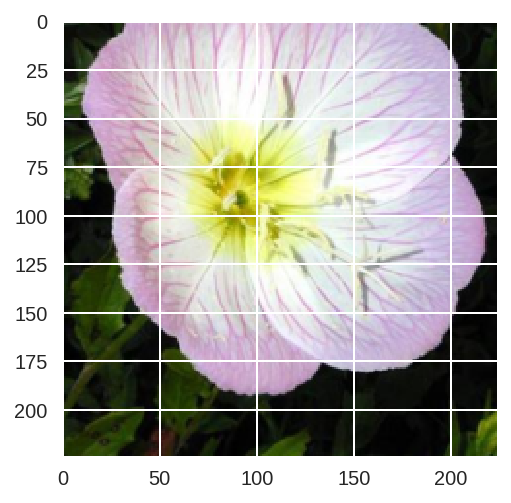

In [41]:
# test
imshow(img)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
# TODO: Implement the code to predict the class from an image file

def predict(image_path, model, device, topk=5):
    ''' 
    Predict the class (or classes) of an image using a trained deep learning model.
    '''
    img = process_image(image_path)
    img = img.unsqueeze_(0) # this is for VGG
    img = img.float()
    
    with torch.no_grad():
        # forward
        output = model(img.to(device))
        
    probability = F.softmax(output.data,dim=1)
    
    return probability.topk(topk)

In [43]:
# test
predict("flowers/test/1/image_06743.jpg", model, device, topk=5)

(tensor([[0.7832, 0.1623, 0.0223, 0.0152, 0.0037]], device='cuda:0'),
 tensor([[ 0, 84, 49, 90, 87]], device='cuda:0'))

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [0]:
# TODO: Display an image along with the top 5 classes
def plot_classification(image_path, prediction, mapper):
    ''' 
    To view an image & its predicted classes.
    
    + prediction- results of function predict(), including probabilities & classes 
    + mapper - a dictionary like {'15': 'yellow iris'} from 'label mapping' section.
    '''
    
        
    p = np.array(prediction[0][0].to(cpu)) #probabilities
    c = np.array(prediction[1][0].to(cpu)) #classes
    c = [str(x) for x in c] # convert classes from number to str

    
    img = Image.open(image_path)
    
    flower_class = image_path.split('/')[-2] # get the class number
    flower_name = mapper[flower_class] # put the class number into name

    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,6), 
                                   ncols=2, nrows=1)
        
    ax1.set_title(flower_name, size = 16)
    ax1.imshow(img)
    ax1.axis('off')
    
    y_pos = np.arange(len(p))
    ax2.barh(y_pos, p * 100)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([mapper[x] for x in c])
    ax2.invert_yaxis()
    
    ax2.tick_params(labelsize=14)
    ax2.set_xlabel('Percentage (%)', fontsize = 14)
    ax2.set_title("Perdicted Classes", size = 16)

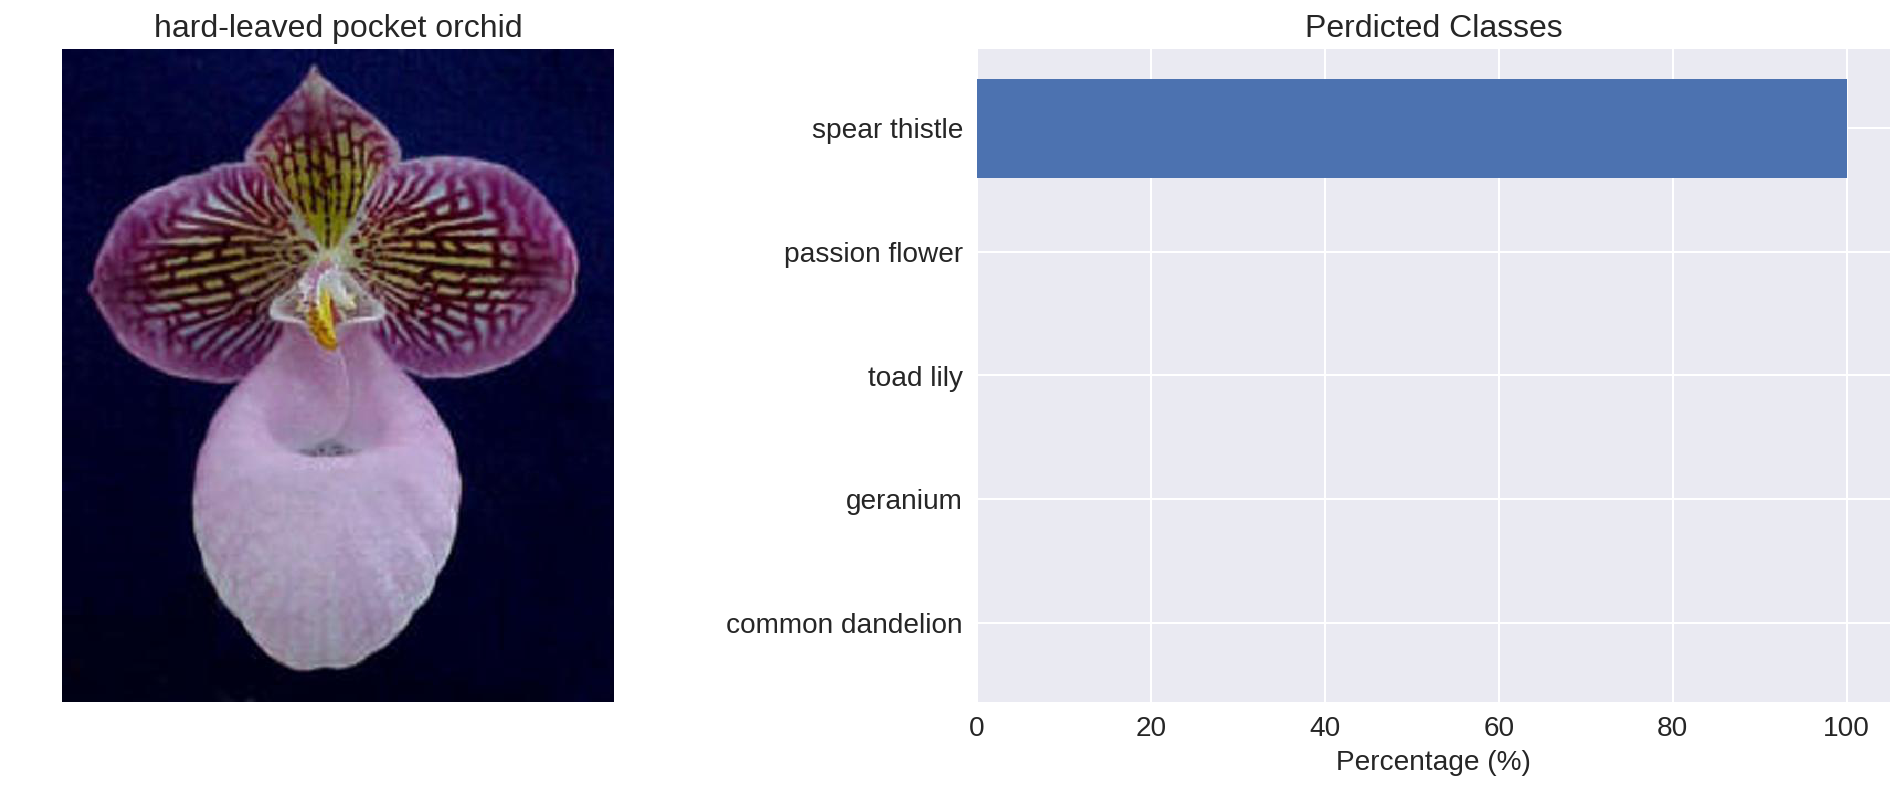

In [46]:
# test
img = 'flowers/test/2/image_05133.jpg'
p = predict(img, model, device, topk=5)


plot_classification(img, p, cat_to_name)